In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.listdir('../data/HAR')

['.DS_Store',
 'activity_labels.txt',
 'features.txt',
 'features_info.txt',
 'README.txt',
 'test',
 'train']

# load dataset

In [15]:
def get_human_dataset() :
    feature_name_df = pd.read_csv('../data/HAR/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])
    
    feature_name = feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv('../data/HAR/X_train.txt', sep = '\s+', names = feature_name)
    X_test = pd.read_csv('../data/HAR/X_test.txt', sep = '\s+', names = feature_name)
    
    y_train = pd.read_csv('../data/HAR/y_train.txt', sep = '\s+', names = ['action'], header = None)
    y_test = pd.read_csv('../data/HAR/y_test.txt', sep = '\s+', names = ['action'], header = None)
    
    return X_train, X_test, y_train,y_test

In [16]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [19]:
y_train.action.value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

# default tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state = 156)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('decision tree accuracy : ', accuracy)

decision tree accuracy :  0.8547675602307431


In [21]:
print('Decision tree 기본 하이퍼 파라미터 : \n', dt.get_params())

Decision tree 기본 하이퍼 파라미터 : 
 {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 156, 'splitter': 'best'}


# hyperparameter

In [22]:
from sklearn.model_selection import GridSearchCV

## max_depth

### cv

In [24]:
params = {
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt, param_grid=params, scoring='accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV best accuracy : ', grid_cv.best_score_)
print('GridSearchCV best hyperparameter : ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.7min finished


GridSearchCV best accuracy :  0.8525571273122959
GridSearchCV best hyperparameter :  {'max_depth': 8}


In [26]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)

cv_result_df[['param_max_depth','mean_test_score','mean_train_score']]

,param_max_depth,mean_test_score,mean_train_score
0,6,0.850925,0.944848
1,8,0.852557,0.982693
2,10,0.850925,0.993403
3,12,0.844124,0.997212
4,16,0.852149,0.999660
5,20,0.851605,0.999966
6,24,0.850245,1.000000


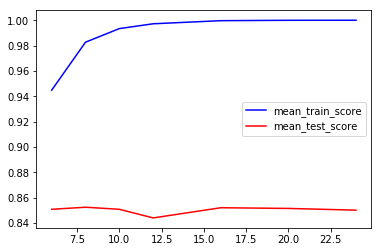

In [45]:
%matplotlib inline
plt.plot(cv_result_df.param_max_depth, cv_result_df.mean_train_score, color = 'blue', label = 'mean_train_score')
plt.plot(cv_result_df.param_max_depth, cv_result_df.mean_test_score, color = 'red', label = 'mean_test_score')
plt.legend()
plt.show()

cv max_depth = 8 일때, best

### test

In [47]:
max_depth = [6,8,10,12,16,20,24]
accuracy_list = []

for depth in max_depth :
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train,y_train)
    pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    accuracy_list.append(accuracy)
    print('max_depth {0} accuracy : {1:.4f}'.format(depth, accuracy))

max_depth 6 accuracy : 0.8551
max_depth 8 accuracy : 0.8734
max_depth 10 accuracy : 0.8717
max_depth 12 accuracy : 0.8616
max_depth 16 accuracy : 0.8612
max_depth 20 accuracy : 0.8605
max_depth 24 accuracy : 0.8595


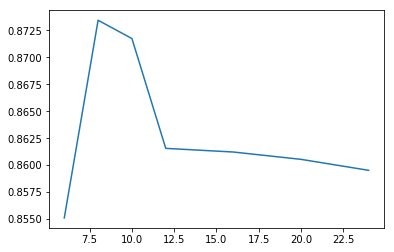

In [48]:
plt.plot(max_depth, accuracy_list)

test도 max_depth = 8일 때 best

## min_samples_split

## cv

In [50]:
params = {
    'max_depth' : [8,12,16,20],
    'min_samples_split' : [16,24]
}

grid_cv = GridSearchCV(dt, param_grid=params, scoring='accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train,y_train)

print("GridSearchCV best accuracy{0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV best hyperparameter{0}".format(grid_cv.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.9min finished


GridSearchCV best accuracy0.8550
GridSearchCV best hyperparameter{'max_depth': 8, 'min_samples_split': 16}


## test

In [51]:
best_dt = grid_cv.best_estimator_
pred1 = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('accuracy : ' , accuracy)

accuracy :  0.8737699355276553


# feature importance

In [52]:
import seaborn as sns

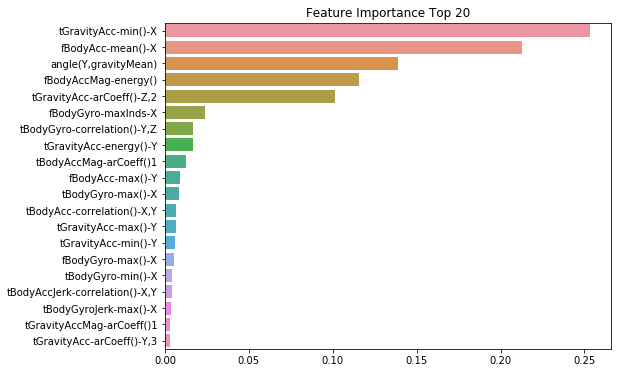

In [57]:
fea_imp = best_dt.feature_importances_
fea_imp = pd.Series(fea_imp, index = X_train.columns)
#sorting TOP20
fea_imp = fea_imp.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature Importance Top 20')
sns.barplot(fea_imp, fea_imp.index)
plt.show()